In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import time
import math
import pickle

In [3]:
filename_Xtrain = '../data/X_train.csv'
filename_ytrain = '../data/y_train.csv'
filename_Xtest = '../data/X_test.csv'
filename_ytest = '../data/y_test.csv'

# Set Pandas to show all the columns
pd.set_option('display.max_columns', None)

# Read the data as a dataframe
X_train = pd.read_csv(filename_Xtrain)
y_train = pd.read_csv(filename_ytrain)

X_test = pd.read_csv(filename_Xtest)
y_test = pd.read_csv(filename_ytest)

In [4]:
y_train = y_train.iloc[:,0]
y_test = y_test.iloc[:,0]

### Decision of parameters

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,roc_curve,roc_auc_score
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix

In [6]:
from sklearn.ensemble import RandomForestClassifier

time of training: 31.210872117678324 minutes
best mean cross-validation score: 0.674
best parameters: {'max_depth': 15}


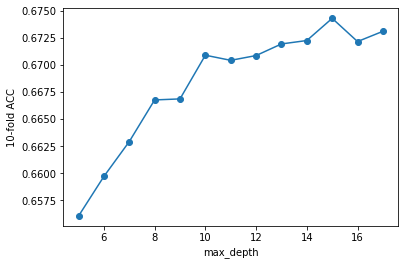

In [7]:
startTime = time.time()

# grid search
maxDepth = range(5,18)
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestClassifier(random_state=0, n_estimators=200, max_features='sqrt'), param_grid=tuned_parameters,cv=10) 
grid.fit(X_train, y_train)

endTime = time.time()
print(f"time of training: {(endTime - startTime)/60} minutes")

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

This is the model that takes for longer (half an hour). However, it is worth it as it is the one with best results, even they are not ideal. 

### Train with the best parameters

In [8]:
maxDepthOptimo = grid.best_params_['max_depth']
bagModel = RandomForestClassifier(max_depth=maxDepthOptimo,n_estimators=200,max_features='sqrt').fit(X_train,y_train)

print("Train: ",bagModel.score(X_train,y_train))
print("Test: ",bagModel.score(X_test,y_test))

Train:  0.9382626517420779
Test:  0.6719636776390465


We see that the accuracy for the testing is good enough. However, we can see that there is some overfitting happening. Therefore, later we will get profit of the features importance information that Random Forest provides us to do a feature selection and see if we can reduce it.

### Save the model

In [10]:
filename = '../models/RandomForest.sav'
pickle.dump(bagModel, open(filename, 'wb'))

### Try with oob_score 

The Random Forest allows us to use the oob_score to take advantage of the data that is hasn't use to train the model. This could replace cross-validation that spends much longer and obtains really similar results. 
<br>
However, we wanted to check if the results were really the same and we did the GridSearchCV as well. For that reason we give to max_depth already the optimal value found by CV. 

In [11]:
mymodel = RandomForestClassifier(max_depth = maxDepthOptimo, n_estimators = 200, max_features = 'auto', oob_score=True)
mymodel.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, n_estimators=200, oob_score=True)

In [12]:
mymodel.oob_score_

0.6686110673183037

Wee see that the metrics are really close, but with CV we decided the best hyperparameter

### Load model

In [5]:
# load the model from disk
filename = '../models/RandomForest.sav'
bagModel = pickle.load(open(filename, 'rb'))
result = bagModel.score(X_test, y_test)
print(result)

0.6719636776390465


### Evaluate the model


--> The classification report is: 
               precision    recall  f1-score   support

         0.0       0.66      0.60      0.63      3684
         1.0       0.68      0.74      0.71      4245

    accuracy                           0.67      7929
   macro avg       0.67      0.67      0.67      7929
weighted avg       0.67      0.67      0.67      7929



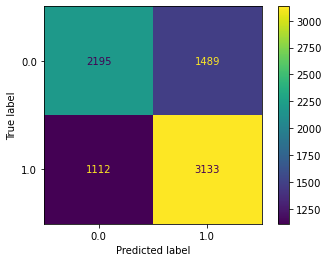

In [15]:
predictionsRF = bagModel.predict(X_test)
print("\n--> The classification report is: \n", classification_report(y_test, predictionsRF))
plot_confusion_matrix(bagModel, X_test, y_test)

We get more than 0.7 that we obtained with the other models for the recall, which is really good news.

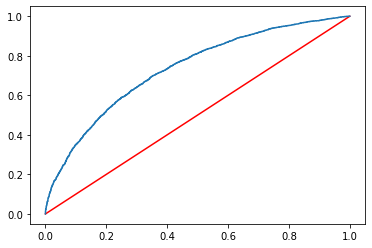

The AUC score is: 0.7337269752113043


In [16]:
probsRF = bagModel.predict_proba(X_test)[:,1]

base_fpr, base_tpr,_ = roc_curve(y_test, [1 for _ in range(len(y_test))])
plt.plot(base_fpr, base_tpr, color = 'r')

fpr,tpr,_ = roc_curve(y_test, probsRF)
plt.plot(fpr,tpr)

plt.show()
print("The AUC score is:", roc_auc_score(y_test,probsRF))

Also the AUC value is significatly better compared to the obtained in the other models. <br>You can find a comparison table in the report attached.

### Get importance of the variables

RandomForest allow us to know which variables are the most important when training and this can help us to do a features selection.

In [17]:
importances = bagModel.feature_importances_
importances = importances / np.max(importances)

feature_importances = list(zip(X_train, importances))
feature_importances_ranked = sorted(feature_importances, key = lambda x:x[1], reverse = True)

for feature,importance in feature_importances_ranked:
    print("Feature: {:35} Importance: {}".format(feature, importance))
    

Feature: kw_avg_avg                          Importance: 1.0
Feature: kw_max_avg                          Importance: 0.855184199200166
Feature: LDA_02                              Importance: 0.6649938026616762
Feature: self_reference_min_shares           Importance: 0.6541641136159803
Feature: self_reference_avg_shares           Importance: 0.6398471933295531
Feature: timedelta                           Importance: 0.6248829438287672
Feature: LDA_01                              Importance: 0.567670557228229
Feature: LDA_04                              Importance: 0.5435650511000867
Feature: LDA_00                              Importance: 0.5236213583378654
Feature: kw_avg_max                          Importance: 0.5190020857413444
Feature: n_unique_tokens                     Importance: 0.5162582989255409
Feature: kw_avg_min                          Importance: 0.5130359346631247
Feature: n_non_stop_unique_tokens            Importance: 0.4976172810311981
Feature: self_reference_max_s

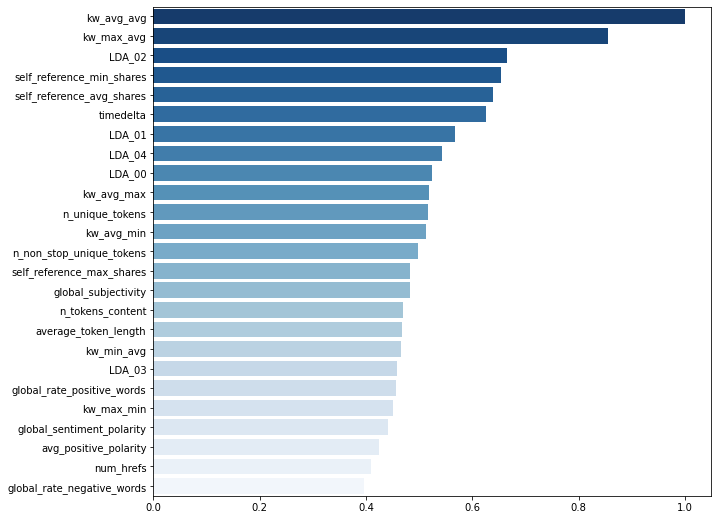

In [18]:
features = []
importances = []
for i in feature_importances_ranked[:25]:
    features.append(i[0])
    importances.append(i[1])

plt.figure(figsize = (10,9))

sns.barplot(x = importances, y = features, palette = "Blues_r")

plt.show()

We can see the 25 most relevant features used for the training of this model

### Data selection

According to the most important features, we select only that data to make the model simpler and see if it works better

In [19]:
X_train_reduced = X_train[features]
X_test_reduced = X_test[features]

### Retrain with selected data

In [21]:
maxDepthOptimo = grid.best_params_['max_depth']
bagModel = RandomForestClassifier(max_depth=maxDepthOptimo,n_estimators=200,max_features='sqrt').fit(X_train_reduced,y_train)

print("Train: ",bagModel.score(X_train_reduced,y_train))
print("Test: ",bagModel.score(X_test_reduced,y_test))

Train:  0.9538704083241368
Test:  0.6545592130155127


We can see that the overfitting persists and that the accuracy gets worse. Therefore, we will keep the model trained with all the features.